# Airbnb data analysis - Mallorca, Spain
In this notebook, we will try to get an idea about the landscape of Airbnb housing in Mallorca, Spain. For that reason, we used the data provided at http://insideairbnb.com/. The datasets describe the listing activity of homestays in the island between April 2020 to April 2021, and it  is basically a snapshot of home-stays  available at a particular time, in this case between 23rd and 25th of April of 2020. 

In addition, we followed the <b>CRISP-DM methodology</b> that consists of (1) business Understanding, (2) data Understanding, (3) data preparation, (4) modeling, (5) evaluation, and (6) deployment.

As of <b>business understanding</b>, we defined the following questions:
- What are the top regions with the highest listings in Airbnb?
- Which types of accommodations are mostly offered?
- What are the prices of accommodations listed?
- What are the reviews and ratings of previous travelers?

## A Look at the Data
In order to get a better <b>understanding of the data</b> to answer our questions, let's take a look at some of the characteristics of the datasets that we will use.

First, let's read in the data and necessary libraries.

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [33]:
listings= pd.read_csv("./listings.csv", low_memory=False, parse_dates=['last_scraped'])
calendar = pd.read_csv("./calendar.csv", parse_dates=['date'])

print(listings.shape)
listings.head()
calendar.head()

(17633, 106)


,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,441723,2020-04-24,f,$69.00,$69.00,3.0,21.0
1,11547,2020-04-24,f,$75.00,$75.00,6.0,1125.0
2,11547,2020-04-25,t,$75.00,$75.00,6.0,1125.0
3,11547,2020-04-26,t,$75.00,$75.00,6.0,1125.0
4,11547,2020-04-27,t,$75.00,$75.00,6.0,1125.0


One of the important things in <b>data understanding</b> is to choose the columns that best answer our questions of interest. We went through the columns list of our 'listings' dataset and some of the interesting columns that we'll be working on are listed below:

- What are the top regions with the highest listings in Airbnb?  
'neighbourhood_cleansed'  
  
- Which types of accommodations are mostly offered?  
'property_type', and 'room_type'  
  
- What are the prices of accommodations listed?  
'price', 'weekly_price', 'monthly_price'  
  
- What are the reviews and ratings of previous travelers?  
'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value'  
  
'calendar' dataset will be used to gain more insight about prices over time in the third question "What are the prices of accommodations listed?". Hence, we will be focusing on 'date', 'available', and 'price' columns.

In [34]:
#List of the columns' names in the dataset
listings.columns.tolist()

['id',
 'listing_url',
 'scrape_id',
 'last_scraped',
 'name',
 'summary',
 'space',
 'description',
 'experiences_offered',
 'neighborhood_overview',
 'notes',
 'transit',
 'access',
 'interaction',
 'house_rules',
 'thumbnail_url',
 'medium_url',
 'picture_url',
 'xl_picture_url',
 'host_id',
 'host_url',
 'host_name',
 'host_since',
 'host_location',
 'host_about',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_thumbnail_url',
 'host_picture_url',
 'host_neighbourhood',
 'host_listings_count',
 'host_total_listings_count',
 'host_verifications',
 'host_has_profile_pic',
 'host_identity_verified',
 'street',
 'neighbourhood',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'city',
 'state',
 'zipcode',
 'market',
 'smart_location',
 'country_code',
 'country',
 'latitude',
 'longitude',
 'is_location_exact',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'bed_type',
 'amenities',


There are many columns that we don't need, so we will start our <b>data preparation</b> by creating a dataframe with the columns of interest.

In [35]:
new_listing = listings[['id',
'listing_url',
'name',
'neighbourhood_cleansed',
'property_type',
'room_type',
'price',
'weekly_price',
'monthly_price',
'calendar_last_scraped',
'number_of_reviews',
'number_of_reviews_ltm',
'first_review',
'last_review',
'review_scores_rating',
'review_scores_accuracy',
'review_scores_cleanliness',
'review_scores_checkin',
'review_scores_communication',
'review_scores_location',
'review_scores_value']]

In [36]:
new_listing.dtypes

id                               int64
listing_url                     object
name                            object
neighbourhood_cleansed          object
property_type                   object
room_type                       object
price                           object
weekly_price                    object
monthly_price                   object
calendar_last_scraped           object
number_of_reviews                int64
number_of_reviews_ltm            int64
first_review                    object
last_review                     object
review_scores_rating           float64
review_scores_accuracy         float64
review_scores_cleanliness      float64
review_scores_checkin          float64
review_scores_communication    float64
review_scores_location         float64
review_scores_value            float64
dtype: object

Our 'new_listing' dataset include some data types that need to be corrected like 'price', 'weekly_price', and 'monthly_price'. However let's check for underfined values first.

In [37]:
new_listing.isna().sum()

id                                 0
listing_url                        0
name                               1
neighbourhood_cleansed             0
property_type                      0
room_type                          0
price                              0
weekly_price                   17110
monthly_price                  17273
calendar_last_scraped              0
number_of_reviews                  0
number_of_reviews_ltm              0
first_review                    6841
last_review                     6841
review_scores_rating            7072
review_scores_accuracy          7076
review_scores_cleanliness       7074
review_scores_checkin           7079
review_scores_communication     7078
review_scores_location          7079
review_scores_value             7081
dtype: int64

The price per night has no missing values while the weekly and monthly prices have so many missing values, so we'll just focus on the price per night. The columns related to reviews' question have many missing values as well but we still can perform our data analysis with them and get good results.   
So, let's put the price in correct format!

In [24]:
new_listing['price'] = new_listing['price'].str.replace('[\$\,]','').astype(float)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Moving to 'calendar' dataset, we'll be performing the same process.

In [25]:
calendar.dtypes

listing_id                 int64
date              datetime64[ns]
available                 object
price                     object
adjusted_price            object
minimum_nights           float64
maximum_nights           float64
dtype: object

In [26]:
calendar.isna().sum()

listing_id        0
date              0
available         0
price             0
adjusted_price    0
minimum_nights    9
maximum_nights    9
dtype: int64

In [38]:
calendar['price'] = calendar['price'].str.replace('[\$\,]','').astype(float)

In principle, we are ready to move to the next step. However, we will be doing more data cleaning like dealing with outliners as part of our <b>data preparation</b> while going through each question .  

We do not need to do any predictive <b>modeling</b>. We we will be only using some descriptive and a little inferential statistics to retrieve the results. So we jump straight to <b>evaluation</b> step.


## What are the top regions with the highest listings in Airbnb?

First we'd like to see what are the top regions with the  highest listings, so we'll group the listings pertaining to each region and count its frequncy.

In [29]:
#Total number of listings
new_listing.id.count()

17633

In [54]:
def type_counting(df, col_name):
    '''
    Returns a dataframe of frequency grouped by column_type.

            Parameters:
                    df - Panda dataframe that we'll retrieve data from it
                    col_name - The column name by which the counting is grouped

            Returns:
                     df_ordered- Panda Dataframe grouped by col_name and ordered by frequency (count)
    '''
     
    df_ordered = df.groupby(by=[col_name]).count()[['id']].sort_values(by= ['id'], ascending=False).reset_index(drop=False)

    return df_ordered

In [57]:
#List of top regions with the highest offer
regions_ordered = type_counting(new_listing, 'neighbourhood_cleansed')
top_regions = regions_ordered['neighbourhood_cleansed'][:10]
top_regions


0             Pollença
1    Palma de Mallorca
2              Alcúdia
3              Manacor
4             Santanyí
5      Santa Margalida
6             Felanitx
7            Llucmajor
8               Campos
9            Capdepera
Name: neighbourhood_cleansed, dtype: object

In [68]:
def plot_histogram(df, col_name):
    '''
    Plots a hisotgram where col_name is the column of interest

            Parameters:
                    df - Panda dataframe that we'll retrieve data from it
                    col_name - The column name of interest

    '''
     
    base_color = sns.color_palette()[0]
    col_counts = df[col_name].value_counts()
    col_order = col_counts.index
    sns.countplot(data = df, y = col_name, color = base_color, order = col_order[:10]);

    n_listings= df.shape[0]
    for i in range(10):
        count = col_counts[i]
        pct_string = '{:0.1f}%'.format(100*count/n_listings)
        plt.text(count, i, pct_string, va = 'center')


Text(0, 0.5, 'Region')

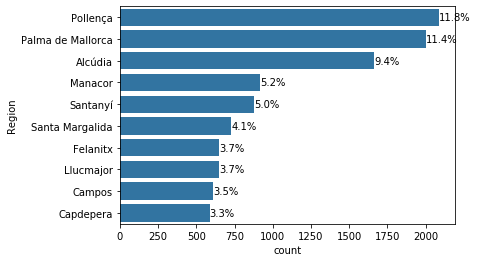

In [69]:
#plot regions
plot_histogram(new_listing, 'neighbourhood_cleansed')
plt.ylabel("Region")

## Which types of accommodations are mostly offered?

Next we'd like to know what types of housing each region offers

In [59]:
#room types
new_listing['room_type'].value_counts()/ new_listing['room_type'].count()

Entire home/apt    0.899110
Private room       0.085578
Hotel room         0.014348
Shared room        0.000964
Name: room_type, dtype: float64

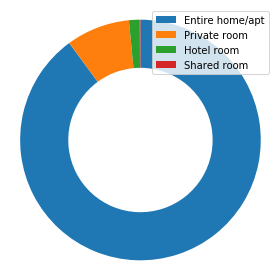

In [60]:
#plot room type
sorted_counts = new_listing['room_type'].value_counts()
labels = sorted_counts.index 
plt.pie(sorted_counts, startangle = 90,
        counterclock = False, wedgeprops = {'width' : 0.4});

plt.legend(labels, loc="best");
plt.axis('square');
plt.tight_layout()

plt.show()


In [61]:
#See where private rooms are concentrated
df_private_room = new_listing.loc[new_listing['room_type'] == 'Private room']
df_private_room.rename(columns = {'neighbourhood_cleansed':'region', 'id':'count'}, inplace = True)
df_private_room.groupby(by=['room_type', 'region']).count()[['count']].sort_values(by= ['room_type', 'count'], ascending=False).head()


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


count
room_type    region                  
Private room Palma de Mallorca    692
             Sóller                57
             Calvià                52
             Llucmajor             51
             Santanyí              46

In [63]:
#Top types of properties
properties_ordered = type_counting(new_listing, 'property_type')
top_properties = properties_ordered['property_type'][:10]
top_properties

0                House
1                Villa
2            Apartment
3              Cottage
4               Chalet
5            Townhouse
6          Condominium
7       Boutique hotel
8    Bed and breakfast
9           Guesthouse
Name: property_type, dtype: object

Text(0, 0.5, 'Property type')

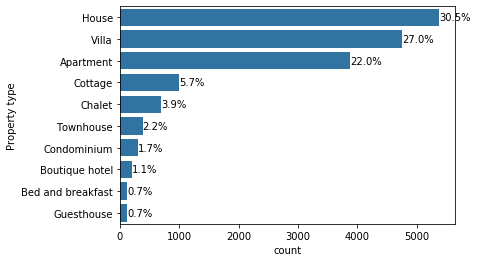

In [70]:
#plot properties
plot_histogram(new_listing, 'property_type')
plt.ylabel("Property type")   

In [10]:
df_top3 = new_listing.loc[new_listing['neighbourhood_cleansed'].isin(top_regions[:3])]
df_top3.rename(columns = {'neighbourhood_cleansed':'region', 'id':'count'}, inplace = True)
fff = df_top3.groupby(by=[ 'region', 'property_type']).count()[['count']].sort_values(by= ['region','count'], ascending=False)
fff.groupby(['region']).head(5)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


count
region            property_type       
Pollença          Villa            986
                  House            434
                  Apartment        433
                  Cottage           73
                  Chalet            48
Palma de Mallorca Apartment       1182
                  House            285
                  Villa            158
                  Loft              48
                  Chalet            45
Alcúdia           Apartment        499
                  Villa            475
                  House            408
                  Chalet           111
                  Townhouse         50

## What are the prices of accommodations listed?
Let's see here the price of a listing per region and per house_type

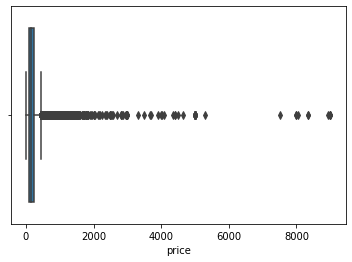

In [27]:
#Exploration of data
sns.boxplot(x = new_listing['price'])

From the boxplot, we can see many outliers but we checked some the listings with highest prices with the prices in official Airbnb website and it match. So our idea is to keep the outliers but we'll zoom in on the data where we have more listings and thus we can understand better the data.

In [48]:
#Price statistics
new_listing.price.describe()

count    17633.000000
mean       213.779901
std        342.103675
min          0.000000
25%         95.000000
50%        149.000000
75%        236.000000
max       9000.000000
Name: price, dtype: float64

Text(0, 0.5, 'Count of listings')

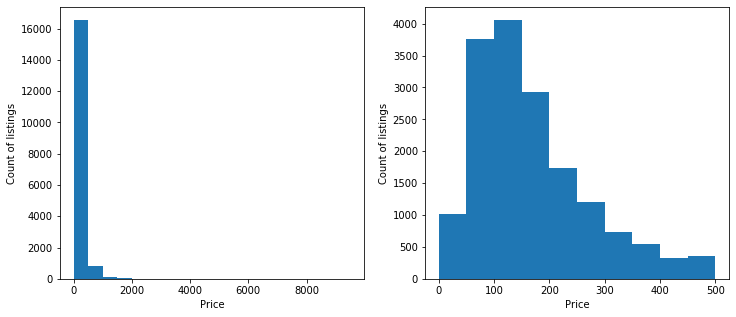

In [49]:
# price plot
plt.figure(figsize = [12, 5])

# histogram on left: full data
plt.subplot(1, 2, 1)
bin_edges = np.arange(0, new_listing['price'].max()+1000, 500)
plt.hist(data = new_listing, x = 'price', bins = bin_edges)
plt.xlabel("Price")
plt.ylabel("Count of listings")
# histogram on right: focus in on bulk of data < 500
plt.subplot(1, 2, 2)
bin_edges = np.arange(0, 500+50, 50)
plt.hist(data = new_listing, x = 'price', bins = bin_edges)
plt.xlabel("Price")
plt.ylabel("Count of listings")


### Price per property type

In [37]:
#property type median price
grouped_property= new_listing.groupby(by=['property_type']).median()[['price']].reset_index(drop=False)
grouped_property.loc[grouped_property['property_type'].isin(top_properties)].sort_values(by =['price'], ascending=False )


,property_type,price
37,Villa,206.0
5,Boutique hotel,198.5
15,Cottage,170.0
13,Chalet,164.5
24,House,150.0
35,Townhouse,119.5
1,Apartment,90.0
3,Bed and breakfast,85.0
14,Condominium,85.0
20,Guesthouse,85.0


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

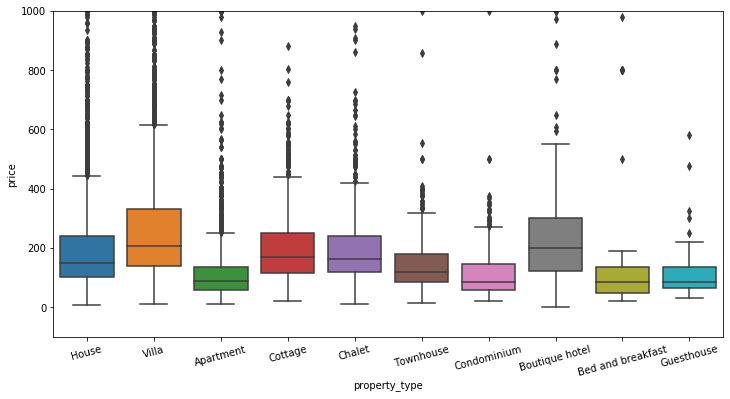

In [26]:
plt.figure(figsize=(12,6))
df= new_listing.loc[new_listing['property_type'].isin(top_properties)]
g = sns.boxplot(data = df, x = 'property_type', y = 'price', order = top_properties)
plt.ylim(-100, 1000)
plt.xticks(rotation = 15)

In [60]:
#room type median price
new_listing.groupby(by=['room_type']).median()[['price']].reset_index(drop=False).rename(columns = {'price': 'median_price'})


,room_type,median_price
0,Entire home/apt,153.0
1,Hotel room,170.0
2,Private room,51.0
3,Shared room,50.0


(-100, 700)

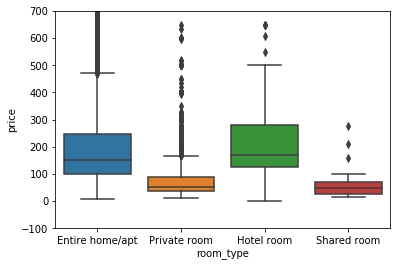

In [28]:
sns.boxplot(data = new_listing, x = 'room_type', y = 'price')
plt.ylim(-100, 700)

For private rooms, we are particularly interested in the price offered in Palma.

In [66]:
grouped_room= new_listing.groupby(by=['room_type', 'neighbourhood_cleansed']).median()[['price']].reset_index(drop=False)
grouped2 = grouped_room.loc[(grouped_room['neighbourhood_cleansed'] == 'Palma de Mallorca') ]
grouped2.sort_values(by= ['price'], ascending=False)

,room_type,neighbourhood_cleansed,price
68,Hotel room,Palma de Mallorca,144.0
33,Entire home/apt,Palma de Mallorca,130.0
110,Private room,Palma de Mallorca,45.0
133,Shared room,Palma de Mallorca,39.5


### Price per region

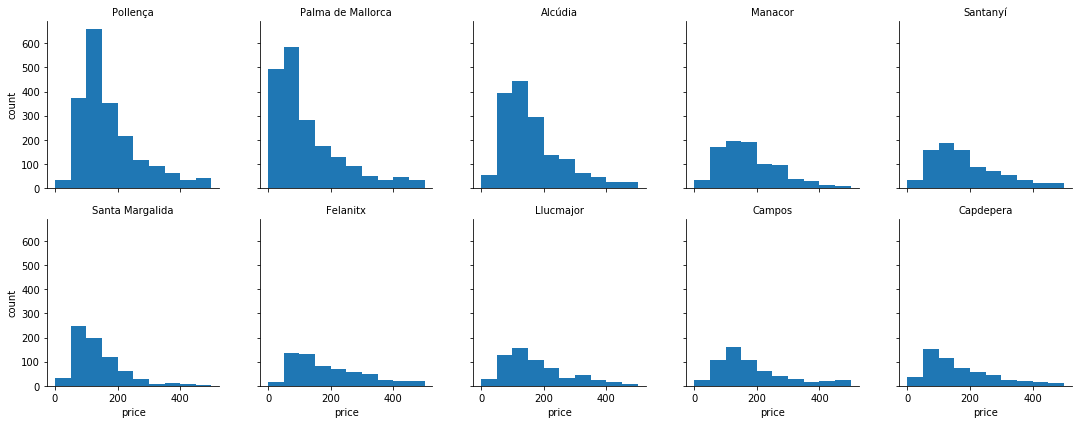

In [46]:
bin_edges = np.arange(0, 500+50, 50)
df= new_listing.loc[new_listing['neighbourhood_cleansed'].isin(top_regions)]
g = sns.FacetGrid(data = df, col = 'neighbourhood_cleansed', col_wrap = 5, col_order = top_regions)
g.map(plt.hist, "price", bins = bin_edges)
g.set_titles('{col_name}')
g.set_ylabels('count')

In [12]:
#median price per region
grouped_region= new_listing.groupby(by=['neighbourhood_cleansed']).median()[['price']].reset_index(drop=False).sort_values(by =['price'], ascending=False)
grouped_region.rename(columns = {'neighbourhood_cleansed':'region', 'price':'median_price'})[:10]


,region,median_price
16,Deyá,237.5
18,Esporles,208.0
3,Andratx,200.0
30,Marratxí,195.0
8,Bunyola,190.0
10,Calvià,183.0
39,Sant Joan,183.0
34,Petra,180.0
17,Escorca,180.0
45,Selva,178.5


### prices, region, property

In [ ]:
grouped_neighbourhood= new_listing.groupby(by=['property_type', 'neighbourhood_cleansed']).mean()[['price']].reset_index(drop=False)
grouped = grouped_neighbourhood.loc[grouped_neighbourhood['neighbourhood_cleansed'].isin(top_regions) & grouped_neighbourhood['property_type'].isin(top_properties[:3]) ]
grouped.sort_values(by= ['property_type', 'price'], ascending=False).head(5)

### Price along time

To get an idea about the prices along the time, we'll use calendar dataset

In [39]:
calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,441723,2020-04-24,f,69.0,$69.00,3.0,21.0
1,11547,2020-04-24,f,75.0,$75.00,6.0,1125.0
2,11547,2020-04-25,t,75.0,$75.00,6.0,1125.0
3,11547,2020-04-26,t,75.0,$75.00,6.0,1125.0
4,11547,2020-04-27,t,75.0,$75.00,6.0,1125.0


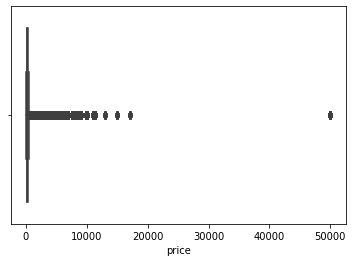

In [40]:
#Exploration of data: checking for outliers
sns.boxplot(x = calendar['price'])

In [41]:
calendar.price.describe()

count    6.436045e+06
mean     2.665629e+02
std      6.428054e+02
min      0.000000e+00
25%      1.040000e+02
50%      1.690000e+02
75%      2.750000e+02
max      4.999900e+04
Name: price, dtype: float64

We'll take just the prices where the listings are available

In [42]:
calendar_available= calendar.loc[(calendar['available'] == "t")]
calendar_available['price'].describe()

count    3.849703e+06
mean     2.394674e+02
std      4.989189e+02
min      8.000000e+00
25%      1.000000e+02
50%      1.600000e+02
75%      2.600000e+02
max      4.999900e+04
Name: price, dtype: float64

The maximum price is too high to be true, a quick check to Airbnb site proves that as well. Maximum price could reach 10000 euros but no more. Thus, we'll remove the outliers as part of <b>data preparation</b>.

In [44]:
# Applying IQR rule for removing outliers
Q1 = calendar_available['price'].quantile(0.25)
Q3 = calendar_available['price'].quantile(0.75)
IQR = Q3 - Q1
calendar_wo = calendar_available[calendar_available['price'].between(Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)] 
calendar_wo['price'].describe()

count    3.587281e+06
mean     1.770358e+02
std      1.042650e+02
min      8.000000e+00
25%      1.000000e+02
50%      1.500000e+02
75%      2.310000e+02
max      5.000000e+02
Name: price, dtype: float64

(array([737546., 737607., 737669., 737730., 737791., 737850., 737911.]),
 <a list of 7 Text xticklabel objects>)

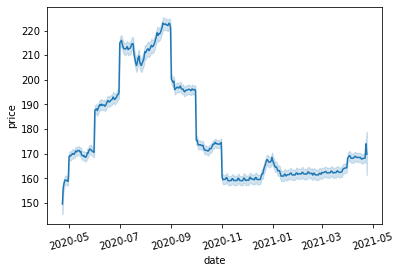

In [45]:
#variation of mean price 
sns.lineplot(data = calendar_wo, x= 'date', y='price', estimator='mean')
plt.xticks(rotation = 15)

Text(0.5, 0, 'Month (Jan=1, Dec=12)')

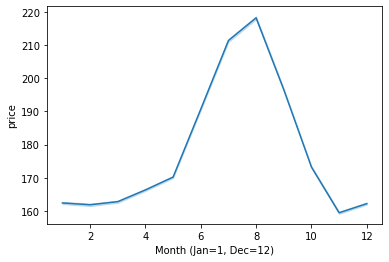

In [46]:
#variation of mean price per month
sns.lineplot(data = calendar_wo, x= calendar_wo.date.dt.month, y='price', estimator='mean')
plt.xlabel("Month (Jan=1, Dec=12)")

Text(0.5, 0, 'Day (Mon=1, Sun=6)')

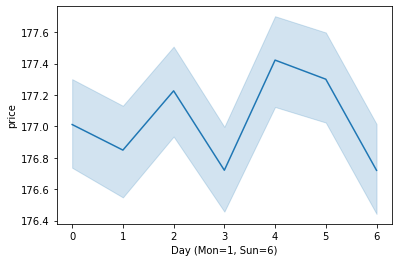

In [47]:
#variation of mean price per week day
sns.lineplot(data = calendar_wo, x= calendar_wo.date.dt.dayofweek, y='price', estimator='mean')
plt.xlabel("Day (Mon=1, Sun=6)")

## What are the reviews and ratings of previous travelers?
Now, let's see what the reviewers say and what they appreciate most

In [5]:
reviews = new_listing [['id',
 'neighbourhood_cleansed',
 'property_type',
 'room_type',
 'number_of_reviews',
 'number_of_reviews_ltm',
 'first_review',
 'last_review',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value']]

reviews.head()

,id,neighbourhood_cleansed,property_type,room_type,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
0,11547,Calvià,Apartment,Entire home/apt,100,13,2011-08-23,2019-10-20,96.0,10.0,9.0,10.0,10.0,10.0,10.0
1,69998,Palma de Mallorca,Loft,Entire home/apt,161,5,2012-01-24,2020-03-15,98.0,10.0,10.0,10.0,10.0,10.0,10.0
2,100831,Santa Margalida,House,Entire home/apt,110,24,2012-08-26,2020-01-25,100.0,10.0,10.0,10.0,10.0,10.0,10.0
3,105891,Maria de la Salut,Townhouse,Entire home/apt,14,2,2012-06-19,2019-09-03,97.0,10.0,10.0,10.0,10.0,9.0,10.0
4,130669,Palma de Mallorca,Apartment,Private room,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Overall rating

In [6]:
reviews.review_scores_rating.describe()

count    10561.000000
mean        93.250544
std          9.212100
min         20.000000
25%         90.000000
50%         96.000000
75%        100.000000
max        100.000000
Name: review_scores_rating, dtype: float64

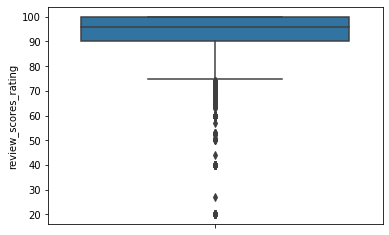

In [7]:
sns.boxplot(data = reviews, y = 'review_scores_rating')

In order to understand the reviews depending on room_type, property_type and region, we'll use the following funtion for getting the mean ratings

In [12]:
def mean_rating (df, type_column):
    '''
    Returns a dataframe of mean ratings grouped by column_type.

            Parameters:
                    df - Panda dataframe that we'll retrieve data from it
                    column_type- The column name by which the ratings are grouped

            Returns:
                    df_rating- Panda Dataframe of mean ratings
    '''
     

    df_rating = pd.DataFrame()
    df_rating['overall rating'] = round(df.groupby(type_column)['review_scores_rating'].mean()/10, 2)
    df_rating['accuracy'] = round(df.groupby(type_column)['review_scores_accuracy'].mean(), 2)
    df_rating['cleanliness'] = round(df.groupby(type_column)['review_scores_cleanliness'].mean(), 2)
    df_rating['check-in'] = round(df.groupby(type_column)['review_scores_checkin'].mean(), 2)
    df_rating['communication'] = round(df.groupby(type_column)['review_scores_communication'].mean(), 2)
    df_rating['location'] = round(df.groupby(type_column)['review_scores_location'].mean(), 2)
    df_rating['value'] = round(df.groupby(type_column)['review_scores_value'].mean(), 2)

    df_rating.sort_values('overall rating', ascending = False)

    return df_rating

### Ratings per room type

In [13]:
room_rating = mean_rating (reviews, 'room_type')
room_rating

,overall rating,accuracy,cleanliness,check-in,communication,location,value
room_type,,,,,,,
Entire home/apt,9.34,9.53,9.42,9.67,9.63,9.46,9.17
Hotel room,9.26,9.31,9.46,9.57,9.55,9.51,9.16
Private room,9.25,9.51,9.33,9.66,9.58,9.45,9.21
Shared room,7.04,7.40,7.00,7.60,7.40,9.00,8.80


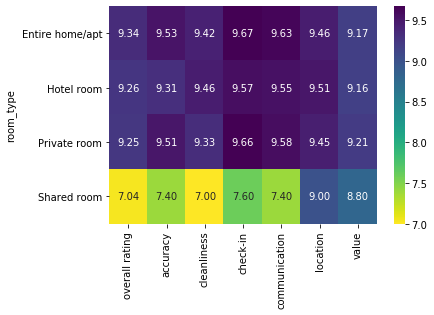

In [14]:
sns.heatmap(data = room_rating, annot = True, fmt = '.2f', cmap = 'viridis_r')

### Property types ratings

In here, we are mostly interested in ratings of the 10 most listed porperty types

In [25]:
reviews_pt= reviews.loc[reviews['property_type'].isin(top_properties)]

property_rating = mean_rating(reviews_pt, 'property_type')
property_rating

,overall rating,accuracy,cleanliness,check-in,communication,location,value
property_type,,,,,,,
Apartment,9.16,9.45,9.29,9.62,9.59,9.56,9.06
Bed and breakfast,9.40,9.63,9.72,9.66,9.65,9.40,9.46
Boutique hotel,9.49,9.50,9.62,9.75,9.53,9.54,9.24
Chalet,9.45,9.55,9.48,9.73,9.67,9.46,9.26
Condominium,9.33,9.54,9.45,9.72,9.69,9.58,9.23
Cottage,9.57,9.68,9.61,9.78,9.79,9.50,9.41
Guesthouse,9.46,9.65,9.60,9.81,9.80,9.51,9.26
House,9.40,9.58,9.47,9.71,9.66,9.44,9.23
Townhouse,9.50,9.74,9.63,9.85,9.84,9.51,9.33


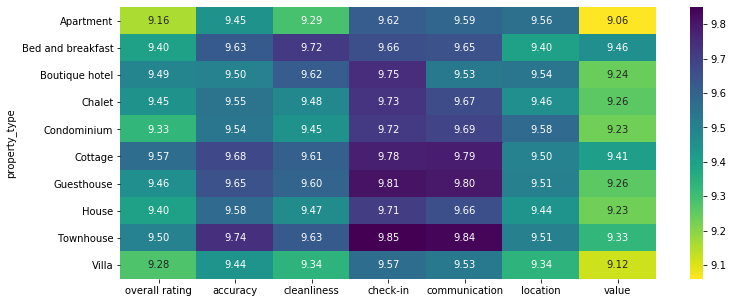

In [22]:
plt.figure(figsize = [12, 5])
sns.heatmap(property_rating, annot = True , fmt = '.2f', cmap = 'viridis_r')

### Ratings per neighborhood

In [24]:
reviews_region= reviews.loc[reviews['neighbourhood_cleansed'].isin(top_regions)]

region_rating = mean_rating (reviews_region, 'neighbourhood_cleansed')
region_rating

,overall rating,accuracy,cleanliness,check-in,communication,location,value
neighbourhood_cleansed,,,,,,,
Alcúdia,9.16,9.42,9.27,9.61,9.59,9.51,9.07
Campos,9.43,9.57,9.44,9.72,9.69,9.36,9.23
Capdepera,9.18,9.30,9.24,9.58,9.41,9.49,9.00
Felanitx,9.42,9.57,9.47,9.70,9.66,9.43,9.23
Llucmajor,9.30,9.44,9.40,9.69,9.65,9.10,9.19
Manacor,9.48,9.56,9.51,9.69,9.71,9.46,9.32
Palma de Mallorca,9.19,9.47,9.28,9.65,9.60,9.48,9.07
Pollença,9.21,9.48,9.33,9.61,9.59,9.57,9.09
Santa Margalida,9.32,9.58,9.42,9.75,9.65,9.45,9.23


Text(86.5, 0.5, 'region')

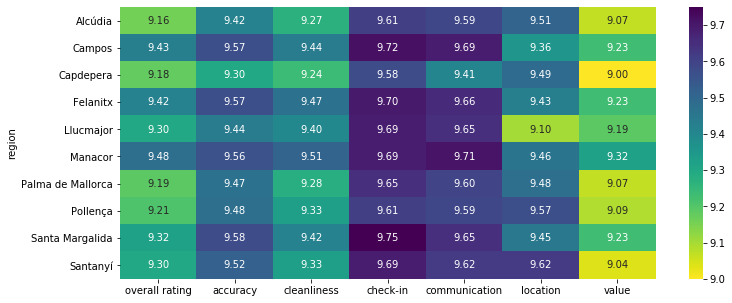

In [26]:
plt.figure(figsize = [12, 5])
sns.heatmap(region_rating, annot = True , fmt = '.2f', cmap = 'viridis_r')
plt.ylabel('region')

## Conclusion
In this notebook, we aimed to answer some questions related to Airbnb landscape in Majorca by adopting CRISP-DM process. As of final step of this process, our results have been <b>deployed</b> in a Medium post that can be found [here](https://medium.com/@ayedins/visiting-majorca-after-lockdown-c75a01ed6061).
